# Assignment 2: Classical Control
Name: Shivam Bhat

Purdue Username: bhat41


In this assignment, you will implement and tune a trajectory following controller for a 2-degree of freedom(DoF) robotic arm, and (optionally) a race car.

## Getting Started

We'll be using OpenAI gym, along with PyBullet, to model the robot's environment.
- [OpenAI gym](https://gym.openai.com/) is a toolkit for developing planning and control algorithms. It provides a standard API that abstracts away the model of the robot's environment. It is primarily used for reinforcement learning agents, but can work with any controller, including the PD controllers you'll build in this assignment.
  - If you've never used gym, be sure to read this short [tutorial](https://gym.openai.com/docs/) before getting started.
- [PyBullet](https://pybullet.org/wordpress/) is an open-source physics engine that we'll use to model the robot.
- [pybullet-gym](https://github.com/benelot/pybullet-gym) is an open-source library that implements a variety of gym environments using PyBullet as the backend. One of these environments is `ReacherPyBulletEnv-v0`, the robotic arm that you'll be working with.

## Installation Instructions
Before running this notebook, you'll need to install `gym` and `pybullet-gym`, like so:
```bash
~ # install gym
~ pip install gym=0.25.2
~ # install pybullet-gym
~ git clone https://github.com/benelot/pybullet-gym.git
~ cd pybullet-gym
~ pip install -e .
```

## Overview: 2-DOF robotic arm

## Instruction ###
### 1. Sometimes on having two pybullet env active, notebook crashes - Both for Q3 and Q6. This can be overcome by closing one before running another.<br>
### 2. Ki=0 for my controller
<br>

In [1]:
conda info --env

# conda environments:
#
base                     /Users/sbhat/miniconda3
cs593                 *  /Users/sbhat/miniconda3/envs/cs593


Note: you may need to restart the kernel to use updated packages.


In [2]:
conda list

# packages in environment at /Users/sbhat/miniconda3/envs/cs593:
#
# Name                    Version                   Build  Channel
anyio                     3.5.0            py39hca03da5_0  
appnope                   0.1.2           py39hca03da5_1001  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py39h1a28f6b_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
attrs                     22.1.0           py39hca03da5_0  
backcall                  0.2.0              pyhd3eb1b0_0  
beautifulsoup4            4.11.1           py39hca03da5_0  
blas                      1.0                    openblas  
bleach                    4.1.0              pyhd3eb1b0_0  
ca-certificates           2023.01.10           hca03da5_0  
certifi                   2022.12.7        py39hca03da5_0  
cffi                      1.15.1           py39h80987f9_3  
cloudpickle               2.2.1                    pypi_0    pypi
comm              

In [3]:
%cd pybullet-gym
!ls
!pip install -e .

/Users/sbhat/Documents/Purdue/purduePrivate/assignments/a2/pybullet-gym
LICENSE.md           __init__.py          pybulletgym
README.md            arm_traj.png         pybulletgym.egg-info
RaceCar              arm_traj_error.png   requirements.txt
RaceCarOG            pd_arm_traj.png      setup.py
Obtaining file:///Users/sbhat/Documents/Purdue/purduePrivate/assignments/a2/pybullet-gym
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pybulletgym
    Found existing installation: pybulletgym 0.1
    Uninstalling pybulletgym-0.1:
      Successfully uninstalled pybulletgym-0.1
  Running setup.py develop for pybulletgym


In [1]:
# load libraries (if this fails, see "Installation Instructions")
import gym
import numpy as np
import pybulletgym.envs
import matplotlib.pyplot as plt
import pybullet

import math

pybullet build time: Feb 14 2023 21:20:29


In [2]:
##-- PARAMS --##
pi=np.pi
l1=0.1
l2=0.11

In [3]:
# initialize the environment

# This try-except is to make sure there is only a single pybullet connection set-up
try:
    env.reset()
except NameError:
    env = gym.make("ReacherPyBulletEnv-v0")

env.render(mode="human")
obs = env.reset()

/Users/sbhat/miniconda3/envs/cs593/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [7]:
pybullet.resetDebugVisualizerCamera(1, 5, -80, np.array([0,0,0]))

The robot arm you will be controlling looks like this:

![RobotArm](robotArm.png)

The base of the robot is at the origin; the links $l_0$ and $l_1$ are 0.1 and 0.11 units long respectively.

The action space of environment is [$\tau_0$,$\tau_1$], where $\tau_0$ and $\tau_1$ are the torques applied to joints $q_0$ and $q_1$ respectively.

Do _not_ use the observation space of the environment to get the robot's position. Instead, use the following class methods to obtain the joint angles:
```python
# To get the current position and angular velocity of q0
q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
# To get the current position and angular velocity of q1
q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()

# To set joint q0 to a particular position. (Use only before running your controller, to initialize the start position)
env.unwrapped.robot.central_joint.reset_position(position, 0)
# To set joint q1 to a particular position. (Use only before running your controller, to initialize the start position)
env.unwrapped.robot.elbow_joint.reset_position(position, 0)
```

Your job is to implement PD controllers that track the trajectory

$$\begin{bmatrix}x(\theta) \\ y(\theta)\end{bmatrix}
= \begin{bmatrix}(0.19 + 0.02 \cos 4\theta)\cos\theta \\ (0.19 + 0.02 \cos 4\theta)\sin\theta\end{bmatrix},
\text{ for }\theta \in [-\pi, \pi]$$

This trajectory is plotted below:

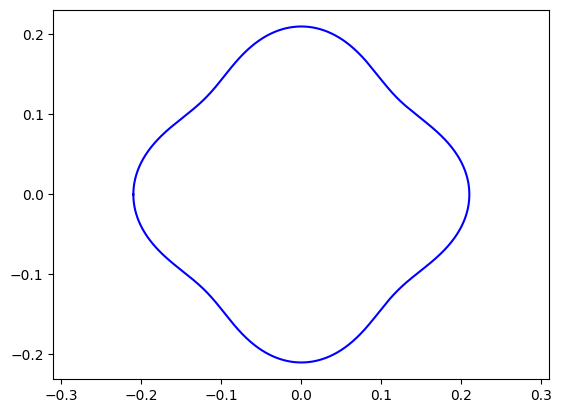

In [11]:
x = [(0.19 + 0.02 * np.cos(theta * 4)) * np.cos(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
y = [(0.19 + 0.02 * np.cos(theta * 4)) * np.sin(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
plt.plot(x, y, 'b')
plt.axis('equal')
# plt.show()
plt.savefig('arm_traj.png')
traj = list(zip(x,y))

### 1. Forward Model 

Derive the forward model for the robot as a closed-form expression expressed in joint angles and link length:

$$f\left(\begin{bmatrix}q_0 \\ q_1\end{bmatrix}\right) =
\begin{bmatrix}
% your answer here
l_0cos(q_0)+l_1cos(q_0+q_1)\\
l_0cos(q_0)+l_1cos(q_0+q_1)
\end{bmatrix}
= \begin{bmatrix} x \\ y\end{bmatrix}$$

Using the robot model parameters, write a function `getForwardModel` that takes the joint states and returns the end-effector position.

In [ ]:
def getForwardModel(q0, q1):
    x=l1*np.cos(q0)+l2*np.cos(q0+q1)
    y=l1*np.sin(q0)+l2*np.sin(q0+q1)
    return [x,y]

### 2. Jacobian

Derive the expression for the Jacobian of the robot:

$$J_f(q_0, q_1) = \begin{bmatrix}
\underline{\;\;\;\;} % your answer here
\end{bmatrix}$$

Derive the expression for the Jacobian of the robot:

$$J_f(q_0, q_1) = \begin{bmatrix}
\frac{\partial x}{\partial q_0},\frac{\partial x}{\partial q_1} \\
\frac{\partial y}{\partial q_0},\frac{\partial y}{\partial q_1}
\end{bmatrix} 
$$
Also we know that,<br>
$x=l_0*cos(q_0)+l_1*cos(q_0+q_1)$ \
$y=l_0*sin(q_0)+l_1*sin(q_0+q_1)$ \
So, on pluggin we get,
$$J_f(q_0, q_1) = \begin{bmatrix}
-l_0sin(q_0)-l_1sin(q_0+q_1), -l_1sin(q_0+q_1) \\
l_0cos(q_0)+l_1cos(q_0+q_1), l_1cos(q_0+q_1))
\end{bmatrix}$$

Write a function `getJacobian` that takes the joint states and returns the Jacobian.

In [38]:
#for my code l1 is l0 and l2 is l2
def getJacobian(q0, q1):
    jaco=np.array([-l1*np.sin(q0)-l2*np.sin(q0+q1),-l2*np.sin(q0+q1),l1*np.cos(q0)+l2*np.cos(q0+q1),l2*np.cos(q0+q1)]).reshape(2,2)
    return jaco

### 3. X-Y controller

**Background:** for reasons beyond the scope of this course, it so happens that, for any robot,
$$\vec \tau = J^T \vec F,$$
where
- $\vec F = \langle F_x, F_y \rangle$ is the force vector exerted by the robot at the end effector
- $\vec \tau = \langle \tau_0, \tau_1 \rangle$ is the vector of torques exerted by the joints
- $J$ is the Jacobian matrix at the current position.

Use this fact to implement a closed-loop PD controller that controls the robot along the trajectory `traj`, using the error in the end-effector as the input signal. Your controller should compute forces $F_x$ and $F_y$, and then use `getJacobian` along with the above equation to translate them into joint torques.

Plot the trajectory of the robot juxtaposed over the desired trajectory, and calculate the mean square error between both paths. Also plot the errors with respect to time, and use those plots to tune your controller.

**Note: Initialize the robot arm to $q_0=\pi$ and $q_1=0$**

In [3]:
def sq_error(A,B):
    ## mean sq error ##
    return np.square(np.subtract(A, B)).mean()

In [4]:
def mse_error(A,B):
    ## mse error ##
    ans= np.square(np.subtract(A, B)).mean()
    return ans

In [5]:
def resetBody():
    env.unwrapped.robot.central_joint.reset_position(pi, 0)
    env.unwrapped.robot.elbow_joint.reset_position(0, 0)

In [6]:
def plot_original_traj(plt):
    x = [(0.19 + 0.02 * np.cos(theta * 4)) * np.cos(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
    y = [(0.19 + 0.02 * np.cos(theta * 4)) * np.sin(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
    plt.plot(x, y)
    plt.axis('equal')

In [7]:
def PdController(kp,kd,goalTraj,useSqrtKD=False):
    import math
    #define the pd controllers
    ## I am choosing Kd=sqrt(Kp)
    Kp=kp
    Kd=kd
    
    if(useSqrtKD==True):
        Kd=sqrt(Kp)

    ## End-effector pos and velocity
    q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
    q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()

    ## store ee points- used for plotting
    ee_pos_track=[]
    mse_track=[]
    err_track=[]

    ##Previous error
    error_pos_prev=np.zeros(2).reshape(2,1)

    for i in range(len(traj)):
        ## get angle configs
        q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
        q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()

        J=getJacobian(q0,q1)

        ## get end-effector position
        ee_x,ee_y=getForwardModel(q0,q1)
        ee_pos=np.array([ee_x,ee_y]).reshape(2,1)

        ## goal end-effector position
        ee_goal=np.array(traj[i]).reshape(2,1)

        ## store position for plotting
        ee_pos_track.append([ee_x,ee_y])

        error_pos=ee_goal-ee_pos
        del_error_pos=error_pos-error_pos_prev
        
        err_track.append(sq_error(ee_goal,ee_pos))

        ## Force for PD controller
        F=Kp*error_pos+Kd*del_error_pos

        ## Calculate and apply torque - Tau = (Transpose(J).F)
        tau=np.dot(J.T,F)
        env.step(tau)

        ## Update last error prev - used for delta error
        error_pos_prev=error_pos

    print("MSE ERROR :{}\n".format(np.mean(err_track)))
#   print("pred len {}".format(len(ee_pos_track)))
    x = [ele[0] for ele in ee_pos_track]
    y = [ele[1] for ele in ee_pos_track]
    plt.plot(x, y, color="r")
    plt.axis('equal')
    plot_original_traj(plt)
    plt.show()
    plt.savefig('pd_arm_traj.png')
    
    plt.plot(range(len(err_track)), err_track, color="y")
    plt.show()


    

MSE ERROR :5.2761670383716196e-08



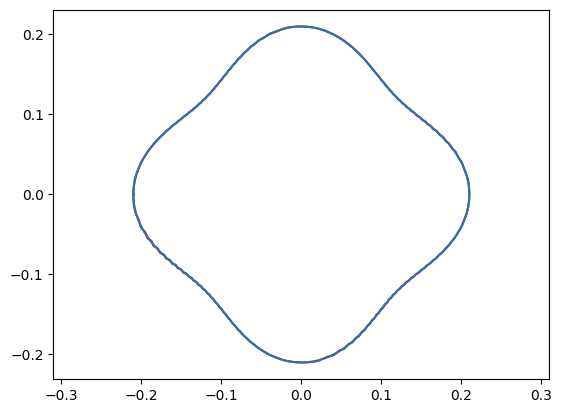

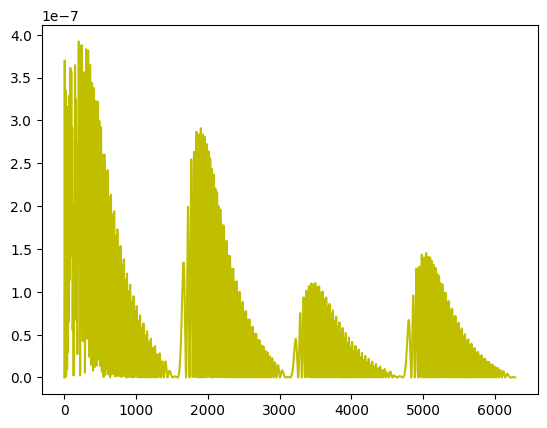

In [19]:
resetBody()
PdController(100,math.sqrt(100),traj)

### 4. Inverse Kinematics

Using the functions `getForwardModel` and `getJacobian` from parts 1 and 2, write a function `getIK` that takes the current end-effector position, target end-effector position, and current joint states; and returns the target joint-states.

In [20]:
def getIK(current_position, target_position, current_state):

    curr_pos=np.array(current_position).reshape(2,1)
    targ_pos=np.array(target_position).reshape(2,1)
    curr_state=np.array(current_state).reshape(2,1)
    
    q0=curr_state[0]
    q1=curr_state[1]
    J=getJacobian(q0,q1)
    Jinv=np.linalg.pinv(J)
    GAMMA=0.1

    e=10000;
    THRESHOLD=0.001
    while(e>THRESHOLD):
        q0=curr_state[0]
        q1=curr_state[1]

        ee_pos=getForwardModel(q0,q1)
        curr_pos=np.array(ee_pos).reshape(2,1)
        
        del_ee_pos=curr_pos-targ_pos
        
        J=getJacobian(q0,q1)
        Jinv=np.linalg.pinv(J)
        
        del_q=Jinv@del_ee_pos
        curr_state=curr_state-(GAMMA*del_q)
#         print("\nDEL Q {}".format(del_q))
        e=mse_error(ee_pos,targ_pos)
#         print("IN Error {}\n".format(e))
    return curr_state


In [21]:
print(getIK([0,0],[0,0.2],[pi,0]))

[[ 13.41392937]
 [-11.1835432 ]]


Now derive the analytical inverse kinematic solution; i.e. solve the problem using a closed-form equation, rather than an iterative method. _Show your work_. Correct answers without derivations will not receive full credit.
\begin{align*}
    % your derivations here
    q_0 &= \underline{\;\;\;\;} \\
    q_1 &= \underline{\;\;\;\;}
\end{align*}

Explain what challenges there would be to use the analytical IK solution to track trajectories:

_<your explanation here\>_

𝑥 = 𝑙0 cos (q0) + 𝑙1 cos(q0 +q1)<br>
𝑦 = 𝑙0 sin (q1) + 𝑙1 sin(q0 +q1)<br><br>
Use formula of cos(x+y) and sin(x+y) here<br><br>
Now to find the inverse kinematics, we need to solve for 𝜃1 and 𝜃2 in terms of 𝑥 and 𝑦. <br>
Using basic Pythagoras theorem to solve for 𝜃1:<br>
𝑙0² + 𝑙1² + 2𝑙0𝑙1 cos(q1) = 𝑥² + 𝑦²<br>
cos(q1) = (𝑥² + 𝑦² - 𝑙0² - 𝑙1²) / (2𝑙0𝑙1)<br>

We can then use the arccosine function to solve for 𝜃2:

q1 = ± acos [(𝑥² + 𝑦² - 𝑙0² - 𝑙1²) / (2𝑙0𝑙1)]

To determine the sign of q1, we need to consider the configuration of the robot arm. If the end-effector is on the opposite side of the 𝑦-axis compared to the origin, we take the negative of the arccosine. Otherwise, we take the positive arccosine.

Next, we can use the law of cosines to solve for q0:

cos(q0) = (𝑙0² + 𝑥² + 𝑦² - 𝑙1² - 2𝑙0(𝑥 cos(q1) + 𝑦 sin(q1))) / (2𝑙0√(𝑥² + 𝑦²))

Again, we can use the arccosine function to solve for q0:

q0 = atan2(𝑦, 𝑥) - atan2(𝑙1 sin(q1), 𝑙0 + 𝑙1 cos(q1))

On Consolidating resulst we get<br>

q1= ± acos [(𝑥² + 𝑦² - 𝑙0² - 𝑙1²) / (2𝑙0𝑙1)]<br>
q0 = atan2(𝑦, 𝑥) - atan2(𝑙1 sin(q1), 𝑙0 + 𝑙1 cos(q1)) <br>

atan is arctan. acos is arccos inverse and likewise<br><br>

Explain what challenges there would be to use the analytical IK solution to track trajectories:<br>

1. Solution Uniqueness: In some cases,like the one shown above (via +- sign for q1) there may be multiple solutions to the analytical IK problem. This happens since for a specific end effector position the arm can be positioned 
in various ways hence with various angles<br><br>

2. The analytical version doesnt incorporate error sensitivity. In iterative one we iterate until it reaches close to goal with certain specified thereshold. This error Threshold hens helps better tune and incorporate error sensitivity too.<br><br>

3. since their can be large float point division within the calculations, analytical IK might be computationally expestive or infeasible 


### 5. IK controller

Implement a closed-loop PD controller that controls the robot along the trajectory `traj`, using the error in the joint-angles as the input signal.

Plot the trajectory of the robot juxtaposed over the actual trajectory and caluclate the mean square error between both paths. Also plot the errors with respect to time, and use those plots to tune your controller.

**Note: Initialize the robot arm to $q_0=\pi$ and $q_1=0$**

In [22]:
# Write your script here.
def PdControllerAngle(kp,kd):
    Kp=kp
    Kd=kd

    ## End-effector pos and velocity
    q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
    q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()

    ## store ee points- used for plotting
    ee_pos_track=[]
    mse_track=[]

    ##Previous error
    error_pos_prev=np.zeros(2).reshape(2,1)
    error_angle_prev=np.zeros(2).reshape(2,1)

    for i in range(len(traj[:6000])):
#         print("-- POINT {}\n --".format(i+1))
        ## get angle configs
        q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
        q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()

        ## get end-effector position
        ee_x,ee_y=getForwardModel(q0,q1)
        ee_pos=np.array([ee_x,ee_y]).reshape(2,1)

#         print("3\n")
        ## goal end-effector position
        ee_goal=np.array(traj[i]).reshape(2,1)

#         print("4\n")
        ## store position for plotting
        ee_pos_track.append([ee_x,ee_y])

#         print("5\n")
        error_pos=ee_goal-ee_pos
        del_error_pos=error_pos-error_pos_prev
        

        goal_angle_raw=getIK(ee_pos,traj[i],[q0,q1])

        goal_angle=np.array(goal_angle_raw).reshape(2,1)

        error_angle=goal_angle-np.array([q0,q1]).reshape(2,1)
        del_error_angle=error_angle-error_angle_prev

        ## Force for PD controller
        F=Kp*error_angle+Kd*del_error_angle
#         print("del error angle: {}\n".format(del_error_angle))

        ## Calculate and apply torque - Tau = (Transpose(J).F)
#         tau=np.dot(J.T,F)
        env.step(F)

        ## Update last error prev - used for delta error
#         error_pos_prev=error_pos
        
        ## Save Error for plot
        ee_position_for_updated_angle=getForwardModel(goal_angle_raw[0],goal_angle_raw[1])
        mse_val=mse_error(ee_goal,ee_position_for_updated_angle)
        mse_track.append(mse_val)
        
        error_angle_prev=error_angle
#         print("\n ** iter:{}".format(i))

#     print("MSE ERROR :{}\n".format(mse_error(traj,ee_pos_track)))
    #print("pred len {}".format(len(ee_pos_track)))
    x = [ele[0] for ele in ee_pos_track]
    y = [ele[1] for ele in ee_pos_track]
    plt.plot(x, y, color="r")
    plt.axis('equal')
    plot_original_traj(plt)
    plt.show()
    plt.savefig('pd_arm_traj.png')
    
    plt.plot(range(len(mse_track)), mse_track, color="y")
    print("MSE:{}\n".format(np.mean(mse_track)))
    plt.show()
    

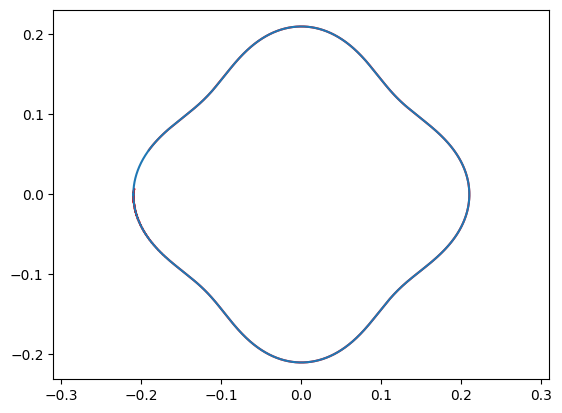

MSE:5.1074760112821436e-08



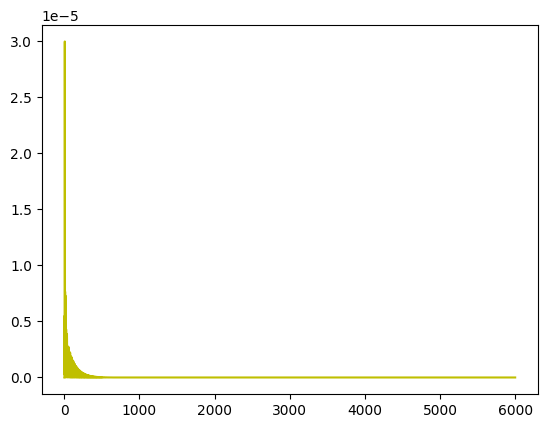

In [23]:
resetBody()
PdControllerAngle(100,math.sqrt(100))

### 6. Race Car

The objective of the `racecar` environment is to make the race car travel as far as possible on a track within the given time. There are 3 tracks vailable: `FigureEight`, `Linear`, and `Circle` (default).
Each track has a different shape, time limit, and horizon length. To set up an environment with a particular track, you can pass the track name while instantiating the environment. For example, to set up the figure eight trajectory:

```python
from racecar.SDRaceCar import SDRaceCar
env = SDRaceCar(render_env=True, track='FigureEight')
```

To install the race car environment, run the following commands:
```bash
~ git clone https://github.com/ucsdarclab/RaceCar.git
~ cd RaceCar
~ pip install -e .
```

The action space of the environment consists of [wheel angle, thrust]. The range of both these values are normalized to be between $\pm 1$.The observation space consists of [$x, y, \theta, v_x, v_y, \dot\theta, h$], where ($x, y, \theta$) is the intertial frame position of the car; $v_x, v_y$ are the longitudinal and lateral velocities  respectively; and $\dot\theta$ is the yaw rate. $h$ is the co-ordinate on the track the car has to reach.

At each time step, the race car environment gives a reward that is proportional to the speed of the car and its proximity to the track. It terminates (`done = True`) after a fixed amount of time, or if the car gets too far from the track.

Using these observations implement a controller that can traverse all three tracks. You may use different gains for different tracks, but the controller itself must be the same. Record the cumulative reward for each track; these rewards will be summed together to create your controller's score. If your controller has the highest score, you win!

_Tip:_ if you call `env.render()` at each step to visualize the car's path, you may find that Jupyter interprets each step as a separate image. To avoid this, try running
```IPython
%matplotlib tk # others include qt, wx, gtk, osx
```
to load results as animations in a separate window. You may have to experiment with several different backends to find the one that works best with your system.

In [26]:
!git clone https://github.com/ucsdarclab/RaceCar.git
%pwd

Cloning into 'RaceCar'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Receiving objects: 100% (28/28), 7.72 KiB | 7.72 MiB/s, done.
Resolving deltas: 100% (7/7), done.


'/Users/sbhat/Documents/Purdue/purduePrivate/assignments/a2/pybullet-gym'

In [8]:
%cd RaceCar
!pip install -e .
%ls

[Errno 2] No such file or directory: 'RaceCar'
/Users/sbhat/Documents/Purdue/purduePrivate/assignments/a2
Obtaining file:///Users/sbhat/Documents/Purdue/purduePrivate/assignments/a2
ERROR: file:///Users/sbhat/Documents/Purdue/purduePrivate/assignments/a2 does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Assignment2.ipynb   arm_traj_2.png      pbcopy              robotArm.png
RaceCarOG/          arm_traj_error.png  pd_arm_traj.png     shivam.py
arm_traj.png        conda_list.txt      pybullet-gym/       shivamTest2.py


In [ ]:
# #### Init ####
# from racecar.SDRaceCar import SDRaceCar
# trk='Circle'
# env = SDRaceCar(render_env=True, track=trk)
# env.reset()

In [9]:
## Race Car Util Functions ##

def get_rotation_mat(angle):
    ans=np.array([np.cos(angle),-np.sin(angle),np.sin(angle),np.cos(angle)]).reshape(2,2)
    return ans

## returns co-ordinated with h as center
def moveXYtoCarFrame(h,x,y):
    return [h[0]-x,h[1]-y]

## rotates the point by theta
def doRotation(theta,point,h):
    ans=0;
    rot_matrix=get_rotation_mat(theta)
    ans=np.transpose(rot_matrix)@np.array(moveXYtoCarFrame(h,point[0],point[1]))
    return ans

def myAngleController(Kp,Kd,pos,err_prev):
    return Kp*np.arctan2(pos[1],pos[0])+Kd*(pos[1]-err_prev)

def thrustController2(KpThrust,KdThrust,x,y,v_x,v_y,h):
    return KpThrust * np.linalg.norm(h - np.array([x, y])) + KdThrust * (-np.linalg.norm([v_x, v_y]))

def myAngleController2(Kp,Kd,pos,err_prev):
    return Kp*np.arctan2(pos[1],pos[0])+Kd*(pos-err_prev)

In [10]:
def raceCarPlay(env,kp_angle,kd_angle,kp_thrust,kd_thrust,pathName,steps):
    # define your controller here
    trk=pathName
#     from racecar.SDRaceCar import SDRaceCar
#     env = SDRaceCar(render_env=True, track=trk)
    env.reset()

    ### main code ###

    %matplotlib tk
    steps=9999
    err_prev=0
    car_pos = np.zeros((2,steps))
    track_pos = np.zeros((2,steps))
    reward=0;
    isPathComplete=False
    en_ret=[0,0,0,0]
    for step in range(steps):
        isPathComplete=en_ret[-2]
#         print(en_ret[-2])
        if(isPathComplete==True):
            break
        reward+=env.reward()
        env.render()
        x, y, theta, v_x, v_y, omega, h=env.get_observation()
        car_pos[0,step], car_pos[1,step] = x, y
        track_pos[0,step], track_pos[1,step] = h[0], h[1]

        rotatedShiftedPos=doRotation(theta,[x,y],h)
        angle=myAngleController(kp_angle,kd_angle,rotatedShiftedPos,err_prev)

        thrust=thrustController2(kp_thrust,kd_thrust,x,y,v_x,v_y,h)
        car_action=[angle,thrust]
#         print("Action {}\n".format(car_action))
        en_ret=env.step(car_action)
#         print("env ret {}\n".format(len(en_ret)))
        err_prev=rotatedShiftedPos[1]
    
    return reward
    # %%



# print(rotation_mat(0.5))
    

In [33]:
from racecar.SDRaceCar import SDRaceCar
rc_env = SDRaceCar(render_env=True,track='Circle')
##PARAMS
KpAngle=3
KdAngle=0.1
KpThrust=6.5
KdThrust=1.45

steps=1000

track="Circle"

circle_rwd=raceCarPlay(rc_env,KpAngle,KdAngle,KpThrust,KdThrust,None,steps)
print("Reward Car:{}".format(circle_rwd))
# run your controller for the 'Circle' environment


Reward Car:211.38460348029358


In [13]:
from racecar.SDRaceCar import SDRaceCar
rc_env = SDRaceCar(render_env=True,track='Linear')
##PARAMS
KpAngle=3
KdAngle=0.1
KpThrust=6.5
KdThrust=1.45

steps=1000

track="Linear"

linear_rwd=raceCarPlay(rc_env,KpAngle,KdAngle,KpThrust,KdThrust,None,steps)
print("Reward Car:{}".format(linear_rwd))
# run your controller for the 'Circle' environment


Reward Car:70.96802949917131


In [25]:
from racecar.SDRaceCar import SDRaceCar
rc_env = SDRaceCar(render_env=True,track='FigureEight')
##PARAMS
KpAngle=3
KdAngle=1
KpThrust=4
KdThrust=1.9

steps=1000

track="FigureEight"

eight_rwd=raceCarPlay(rc_env,KpAngle,KdAngle,KpThrust,KdThrust,None,steps)
print("Reward Car:{}".format(eight_rwd))
# run your controller for the 'Circle' environment


Reward Car:314.5439654137004


In [34]:
print("Total Reward: {}\n".format(circle_rwd+linear_rwd+eight_rwd))

Total Reward: 596.8965983931653



In [ ]:
rc_env = SDRaceCar(render_env=True,track='FigureEight')
# run your controller for the 'FigureEight' environment
